In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Sequence, Tuple
from antea.elec import tof_functions as wvf 
from scipy import signal
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from proposals import SQRT_integrator
from proposals import LOG_integrator
from proposals import LIN_integrator
from waveforms import wave_gen
from optimization import evaluation

%matplotlib nbagg
%reload_ext autoreload
%autoreload 2

In [2]:
time_unit    = 100E-12
PULSE_LENGTH = 5000
PE_inc       = 0.25
MAX_PE       = 1000
LSB_PE_L     = 4
TIME         = np.arange(0,((MAX_PE+1)/PE_inc)*PULSE_LENGTH,PULSE_LENGTH)
PE           = np.arange(0,MAX_PE+1,PE_inc)
#TIME_rnd = np.add.accumulate(np.random.poisson(9,100))
#PE_rnd   = np.random.choice([1,2],100,replace=True,p=[0.95,0.05])
#TIME_rnd     = np.array([ 500, 570,1000,1040,1060,1100,1110,1160,1200,1230,1300,
#                          1400,1440,1460,1500,1510,1560,1600,1630,1700,1710,1750])
#PE_rnd       = np.array([   1,   4,  30,  40,  25,  15,  20,  25,  30,  10,   4,   
#                           25,  35,  20,  10,  40,  30,  15,  10,   5,   4,   1])

### MAX NUMBER OF PE = 1000
### LINEAR CONVERSION  --   PE = (very_low_number) LSB !!!! (Not a good idea)
### Noise threshold (est.) = 80uV  /  80nA

In [3]:
time,signal_out = wave_gen(np.vstack([TIME,PE]), time_unit, Bandwidth=25E6)
#plt.figure()
#plt.plot(signal_out)

CHECK: Electrons in spe_response = 1.000000


# TEST & COMPARISION

In [4]:
testbench = evaluation(time_unit = time_unit,
                        max_pe    = MAX_PE,
                        lsb_pe    = LSB_PE_L,
                        pulse_length = PULSE_LENGTH,
                        signal    = signal_out,
                        PE_array  = PE,
                        PE_inc    = PE_inc)


mosfet_params = {'KPP_2n':150E-6, 'W_L':10,  'VTH':0.55}
caps          = {'cap0':7E-12,  'cap1':1E-12, 'cap2':0.6E-12}

I1_lin = LIN_integrator(KPP_2n = mosfet_params['KPP_2n'],W_L = mosfet_params['W_L'],VTH = mosfet_params['VTH'],
                            time_unit = time_unit,
                            cap = caps['cap0'],
                            I_o = 10E-6,
                            I_a = 10E-6)

I1_sqrt = SQRT_integrator(KPP_2n = mosfet_params['KPP_2n'],W_L = mosfet_params['W_L'],VTH = mosfet_params['VTH'],
                            time_unit = time_unit,
                            cap = caps['cap0'],
                            I_o = 10E-6,
                            I_a = 5E-6)

I2_log = LOG_integrator(KPP_2n = mosfet_params['KPP_2n'],W_L = mosfet_params['W_L'],VTH = mosfet_params['VTH'],
                                time_unit = time_unit,
                                cap1  = caps['cap1'],
                                cap2 = caps['cap2'],
                                R    = 11E3,
                                Ibias1 = 10E-6,
                                Ibias2 = 10E-6,
                                Ibias3 = 80E-6)



In [14]:
GAIN_lin = 0.25
LSB_lin  = 1.4*240E-9
LSB_sqrt_log = 1.68*240E-6
#LSB_lin = PE_current/LSB_PE_L

Iout_lin  = testbench.get_integral(I1_lin,GAIN_lin)
Vout_sqrt = testbench.get_integral(I1_sqrt,1)
Vout_log  = testbench.get_integral(I2_log,1)

# LINEAR INTEGRATOR (COMPANDER)
N_BITS_L = 11
MAX_current = np.max(Iout_lin)
PE_current = np.min(Iout_lin)/PE_inc
print("LINEAR COMPANDER")
print("Full Scale output current %e (required DR = %e (LSB) / available DR = %e (LSB) )" 
       % (MAX_current,MAX_current/LSB_lin,2**N_BITS_L))
print("Integrated PE value = %e (%e LSB)" % (PE_current,PE_current/LSB_lin))
print("LSB = %e V" % LSB_lin)
PE_LSB_LUT_L, LSB_per_PE_L = testbench.lsb_2_pe(I1_lin,N_BITS_L,LSB_lin,GAIN_lin)
RES_L = testbench.res_compute(PE_LSB_LUT_L, LSB_per_PE_L)

# SQUARE ROOT INTEGRATOR (COMPRESSOR)
N_BITS_SQRT = 9
GAIN_SQRT = 1
MAX_voltage_SQRT = np.max(Vout_sqrt)
MIN_voltage_SQRT = np.min(Vout_sqrt)
print("\nSQUARE ROOT COMPRESSOR")
print("Full Scale output voltage %e" % (MAX_voltage_SQRT-mosfet_params['VTH']))
print("Minimum output voltage %e" % (MIN_voltage_SQRT-mosfet_params['VTH']))
PE_LSB_LUT_SQRT,LSB_per_PE_SQRT = testbench.lsb_2_pe(I1_sqrt, N_BITS_SQRT, LSB_sqrt_log,
                                                     GAIN_SQRT, mosfet_params['VTH'])
RES_SQRT = testbench.res_compute(PE_LSB_LUT_SQRT,LSB_per_PE_SQRT)

# LOGARITHMIC INTEGRATOR (COMPRESSOR)
N_BITS_LOG = 11
GAIN_LOG = 1
MAX_voltage_LOG = np.max(Vout_log)
MIN_voltage_LOG = np.min(Vout_log)
print("\nLOGARITHMIC COMPRESSOR")
print("Full Scale output voltage %e" % MAX_voltage_LOG)
print("Minimum output voltage %e" % MIN_voltage_LOG)
PE_LSB_LUT_LOG,LSB_per_PE_LOG = testbench.lsb_2_pe(I2_log,N_BITS_LOG,LSB_sqrt_log,GAIN_LOG)
RES_LOG = testbench.res_compute(PE_LSB_LUT_LOG,LSB_per_PE_LOG)

LINEAR COMPANDER
Full Scale output current 7.012983e-04 (required DR = 2.087197e+03 (LSB) / available DR = 2.048000e+03 (LSB) )
Integrated PE value = 7.007355e-07 (2.085522e+00 LSB)
LSB = 3.360000e-07 V


/home/viherbos/GITHUB/NEXT_ASIC_devel/optimization.py:63: RuntimeWarning: invalid value encountered in true_divide
  aux = np.divide(np.array([x for x in np.arange(0,2**Nbits)]),outA)



SQUARE ROOT COMPRESSOR
Full Scale output voltage 9.669873e-01
Minimum output voltage 1.528328e-02


/home/viherbos/GITHUB/NEXT_ASIC_devel/optimization.py:63: RuntimeWarning: divide by zero encountered in true_divide
  aux = np.divide(np.array([x for x in np.arange(0,2**Nbits)]),outA)
/home/viherbos/GITHUB/NEXT_ASIC_devel/optimization.py:68: RuntimeWarning: invalid value encountered in true_divide
  RES = np.divide(np.divide(np.ones(len(LSB_per_PE)),LSB_per_PE),PE_LSB_LUT)*100



LOGARITHMIC COMPRESSOR
Full Scale output voltage 8.291871e-01
Minimum output voltage 4.125154e-03


<IPython.core.display.Javascript object>


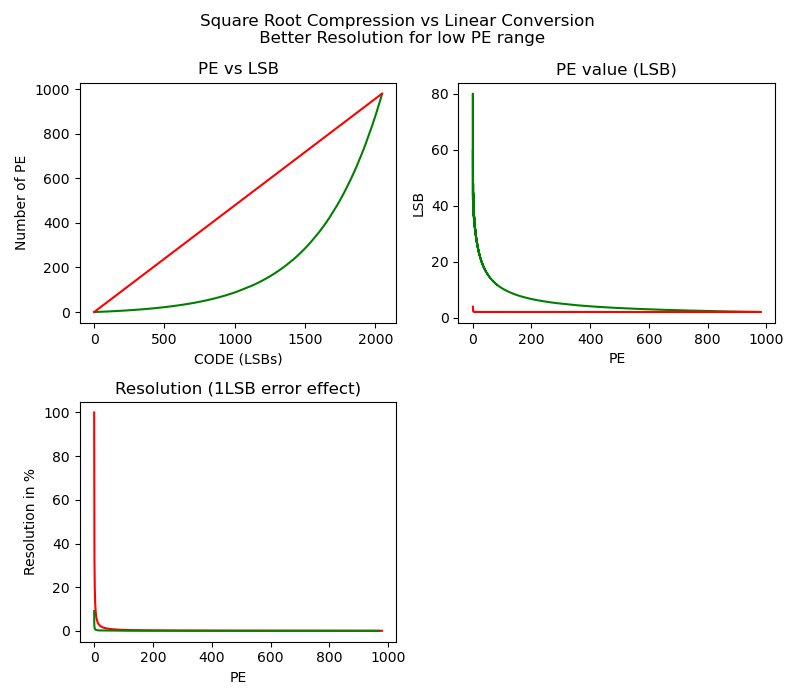

In [15]:
fig2 = plt.figure(figsize=(8,7))

In [16]:
fig2.suptitle("Square Root Compression vs Linear Conversion \n Better Resolution for low PE range")
SP1 = fig2.add_subplot(221)
SP1.set_title("PE vs LSB")
SP1.set_xlabel("CODE (LSBs)")
SP1.set_ylabel("Number of PE")
#SP1.plot(PE_LSB_LUT_SQRT,'b')
SP1.plot(PE_LSB_LUT_LOG,'g')
SP1.plot(PE_LSB_LUT_L,'r')

SP2 = fig2.add_subplot(222)
SP2.set_title("PE value (LSB)")
SP2.set_xlabel("PE")
SP2.set_ylabel("LSB")
#SP2.plot(PE_LSB_LUT_SQRT,LSB_per_PE_SQRT,'b')
SP2.plot(PE_LSB_LUT_LOG,LSB_per_PE_LOG,'g')
SP2.plot(PE_LSB_LUT_L,LSB_per_PE_L,'r')

SP3 = fig2.add_subplot(223)
SP3.set_title("Resolution (1LSB error effect)")
SP3.set_xlabel("PE")
SP3.set_ylabel("Resolution in %")
#SP3.plot(PE_LSB_LUT_SQRT[0:-5],RES_SQRT[0:-5],'b')
SP3.plot(PE_LSB_LUT_L[0:-5],RES_L[0:-5],'r')
SP3.plot(PE_LSB_LUT_LOG[0:-5],RES_LOG[0:-5],'g')

plt.show()
fig2.tight_layout()